# Information Retrieval

## Overview

This lab provides hands-on practice building a complete **Search Engine** from scratch using **TF-IDF (Term Frequency-Inverse Document Frequency)**, one of the most common techniques in Information Retrieval. You'll work with real datasets, implement TF-IDF vectorization, measure document similarity using cosine similarity, and build a functional search engine that can retrieve and rank documents based on user queries. This lab demonstrates the practical application of IR concepts in building production-ready search systems.

> A 2015 survey showed that 83% of text-based recommender systems in digital libraries used TF-IDF.

## Outline

1. **Setup and Imports** - Installing dependencies and importing libraries
2. **Dataset Loading** - Loading the 20 Newsgroups dataset from scikit-learn
3. **Text Preprocessing** - Preparing documents for vectorization
4. **TF-IDF Vectorization** - Converting documents and queries into numerical vectors
5. **Building the Search Engine**:
   - **Retrieval**: Finding the most similar documents to a query using cosine similarity
   - **Ranking**: Ordering documents by relevance score
   - **Classification**: Classifying queries into one of the 20 categories
6. **Testing the Search Engine** - Querying and evaluating results
7. **Understanding Results** - Interpreting search results and similarity scores

## Learning Objectives

By the end of this lab, you will be able to:

- Recognize the term-document matrix produced by the TF-IDF algorithm
- Understand how similarity is measured between text vectors (cosine similarity)
- **Work with real datasets**.
- **Implement a TF-IDF-based search engine** using:
  - Scikit-learn's `TfidfVectorizer`
  - Cosine similarity for document ranking
  - Sparse matrices for efficient storage

## Glossary of Terms

**Information Retrieval (IR)**: The task of finding information (usually documents) that satisfies an information need from within large collections.

**Corpus**: A collection of documents. In IR, this is the entire set of documents we search through.

**Query**: A user's information need expressed in natural language (e.g., "What is machine learning?").

**Document**: A unit of information in the corpus (e.g., a web page, article, or text passage).

**TF-IDF (Term Frequency-Inverse Document Frequency)**: A numerical statistic that reflects how important a word is to a document in a collection. As you learned in the vectorization lesson:
- **TF (Term Frequency)**: How often a term appears in a document
- **IDF (Inverse Document Frequency)**: How rare or common a term is across the entire corpus
- **TF-IDF**: TF × IDF, giving higher weight to terms that are frequent in a document but rare in the corpus

**Vector Space Model**: A model where documents and queries are represented as vectors in a high-dimensional space. Similarity is measured using the angle between vectors (cosine similarity).

**Cosine Similarity**: A measure of similarity between two vectors. It measures the cosine of the angle between them, ranging from -1 to 1 (or 0 to 1 for non-negative vectors like TF-IDF).

**Sparse Matrix**: A matrix where most elements are zero. TF-IDF vectors are typically sparse because most words don't appear in most documents.

**Retrieval**: The process of finding and ranking documents in response to a query.

**Ranking**: Ordering retrieved documents by their relevance score (highest to lowest).

## References

- [20 Newsgroups Dataset](https://scikit-learn.org/stable/datasets/real_world.html#the-20-newsgroups-text-dataset)
- [Scikit-learn TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
- [Scikit-learn cosine_similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html)

## The Complete Pipeline

1. **Dataset Loading**: Load the 20 Newsgroups dataset from scikit-learn
2. **Text Preprocessing**: Prepare documents for vectorization (as learned in previous lessons)
3. **TF-IDF Vectorization**: Convert documents and queries into numerical vectors
4. Model:
   1. **Retrieval**: Find the most similar documents to a query using **cosine similarity**
   2. **Classification**: Classify a query into one of the 20 categories

### Import Libraries

We group imports by category following Python best practices. All libraries used here are part of the standard scikit-learn ecosystem:


In [1]:
# %pip install joblib==1.5.3 numpy==1.26.4 pandas==2.3.3 scikit-learn==1.8.0 --quiet

In [2]:
# Standard library imports
import json
from collections import defaultdict

# Third-party imports
import numpy as np
import pandas as pd

# Machine Learning
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

print("Libraries imported successfully!")

Libraries imported successfully!


## Loading the 20 Newsgroups Dataset

We'll use scikit-learn's **20 Newsgroups dataset**, a collection of approximately 20,000 newsgroup documents, partitioned across 20 different newsgroups. This is a classic dataset for text classification and information retrieval experiments.

**About the Dataset:**
- **20 categories** of newsgroups (e.g., comp.graphics, rec.sport.baseball, sci.med)
- Each document is a newsgroup post with subject and body text
- Documents are organized by topic, which we'll use to create relevance judgments

We'll load the 20 Newsgroups dataset using scikit-learn's `fetch_20newsgroups` function. This dataset contains newsgroup posts organized into 20 categories.


In [3]:
from sklearn.datasets import fetch_20newsgroups

In [4]:
fetch_20newsgroups?

In [5]:
# Load the 20 Newsgroups dataset
# We'll use the training set as our document collection
# remove=('headers', 'footers', 'quotes') removes metadata to focus on content
print("Loading 20 Newsgroups dataset...")
newsgroups = fetch_20newsgroups(
    subset='train',
    remove=('headers', 'footers', 'quotes'),
    shuffle=True,
    random_state=42,
)

Loading 20 Newsgroups dataset...


### Exercise 1: Explore the Dataset

**Task:**

- The distribution of documents across categories
- The content of sample documents
- Notice that documents are organized by topic (category)

In [6]:
df = pd.DataFrame({
    'text': newsgroups.data,
    'category': newsgroups.target,
    'category_name': [newsgroups.target_names[newsgroups.target[i]] for i in range(len(newsgroups.target))]
})
df.head()

,text,category,category_name
0,I was wondering if anyone out there could enli...,7,rec.autos
1,A fair number of brave souls who upgraded thei...,4,comp.sys.mac.hardware
2,"well folks, my mac plus finally gave up the gh...",4,comp.sys.mac.hardware
3,\nDo you have Weitek's address/phone number? ...,1,comp.graphics
4,"From article <C5owCB.n3p@world.std.com>, by to...",14,sci.space


<Axes: xlabel='category'>

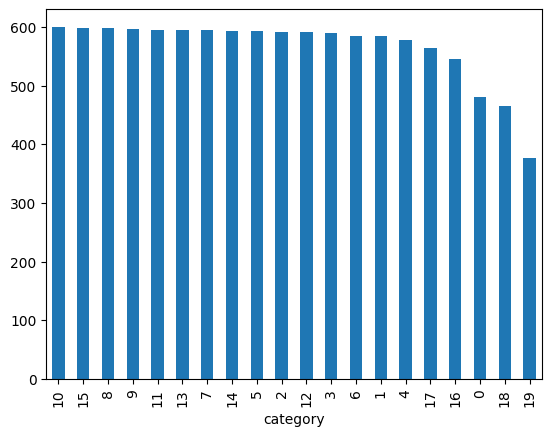

In [7]:
df['category'].value_counts().plot.bar()

### Drop columns and keep `text` only

In [8]:
df = df[['text']]
df

,text
0,I was wondering if anyone out there could enli...
1,A fair number of brave souls who upgraded thei...
2,"well folks, my mac plus finally gave up the gh..."
3,\nDo you have Weitek's address/phone number? ...
4,"From article <C5owCB.n3p@world.std.com>, by to..."
...,...
11309,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...
11310,"I have a (very old) Mac 512k and a Mac Plus, b..."
11311,I just installed a DX2-66 CPU in a clone mothe...
11312,\nWouldn't this require a hyper-sphere. In 3-...


## Building the Search Engine

Now we'll build a TF-IDF-based search engine. The process involves:

1. **Creating TF-IDF vectors** for all documents
2. **Implementing a retrieval function**

### How TF-IDF enables retrieval

- TF-IDF weights words by their importance: rare words that appear frequently in a document get high scores
- When a user searches for "machine learning", documents with high TF-IDF scores for those terms are likely relevant
- The query is also converted to a TF-IDF vector, then compared to all document vectors

**Cosine Similarity for Document Matching**

To find relevant documents, we need to measure **similarity** between the query vector and document vectors.

**Cosine Similarity** measures the angle between two vectors:
- It ranges from -1 to 1 (or 0 to 1 for non-negative vectors like TF-IDF)
- **1.0** = vectors point in the same direction (very similar)
- **0.0** = vectors are perpendicular (no similarity)
- **-1.0** = vectors point in opposite directions (very dissimilar)

**Why cosine similarity?**
- It measures similarity in **direction**, not magnitude
- A long document and a short document about the same topic will have similar directions (high cosine similarity)
- It's robust to document length differences
- Works well with sparse TF-IDF vectors

**The retrieval process:**
1. Convert query to TF-IDF vector (using the same vocabulary as documents)
2. Compute cosine similarity between query vector and all document vectors
3. Rank documents by similarity score (highest first)
4. Return top-k most similar documents

### Task 1: Creating TF-IDF vectors for all documents

In [9]:
# Step 2: Create TF-IDF vectors for all documents
# Initialize the vectorizer
# We use default settings, but you can customize:
# - max_features: limit vocabulary size
# - stop_words: remove common words ('english')
# - ngram_range: use unigrams and bigrams
vectorizer = TfidfVectorizer(
    lowercase=True,      # Convert to lowercase
    stop_words='english', # Remove English stop words
    max_features=5000,   # Limit vocabulary to top 5000 terms
    ngram_range=(1, 2)   # Use both unigrams and bigrams
)

In [10]:
# Fit on all documents and transform them
# This learns the vocabulary and IDF from the corpus
document_vectors = vectorizer.fit_transform(df['text'])
document_vectors

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 504063 stored elements and shape (11314, 5000)>

In [11]:
print(f"Document vectors shape: {document_vectors.shape}")
print(f"  - {document_vectors.shape[0]} documents")
print(f"  - {document_vectors.shape[1]} features (terms in vocabulary)")
print("\nThis is a sparse matrix. Let's check sparsity:")
print(f"  - Non-zero elements: {document_vectors.nnz:,}")
print(f"  - Total elements: {document_vectors.shape[0] * document_vectors.shape[1]:,}")
print(f"  - Sparsity: {(1 - document_vectors.nnz / (document_vectors.shape[0] * document_vectors.shape[1])) * 100:.2f}%")

Document vectors shape: (11314, 5000)
  - 11314 documents
  - 5000 features (terms in vocabulary)

This is a sparse matrix. Let's check sparsity:
  - Non-zero elements: 504,063
  - Total elements: 56,570,000
  - Sparsity: 99.11%


> Notice how the sparse matrix efficiently stores only non-zero values. This is why TF-IDF scales well to large document collections.

- Document vectors shape: (~11,000, 5000) - thousands of documents, 5000 features
- High sparsity (typically 95-99%) - most values are zero

Notice how there is a lot of junk in the text, when we print the vocabulary from `200:400`, this may or may not be useful, depending on your use case.

In [12]:
# Show some vocabulary terms
vocab = vectorizer.get_feature_names_out()
print(vocab[200:400])

['42' '43' '44' '45' '46' '47' '48' '486' '49' '4e' '4k' '4l' '4t' '4th'
 '4u' '50' '500' '5000' '51' '52' '53' '54' '55' '56' '57' '58' '59' '5g'
 '5g9p' '5g9v' '5k' '5s' '5u' '60' '600' '6000' '61' '617' '62' '63' '64'
 '64 bit' '65' '650' '66' '67' '68' '69' '6e' '6ei' '6ei 6ei' '6g' '6um'
 '6um 6um' '70' '700' '703' '71' '72' '73' '74' '75' '750' '75u' '75u 75u'
 '76' '77' '78' '79' '7ex' '7ey' '7ey 7ey' '7ez' '7klj' '7kn' '7th' '7u'
 '80' '80 bit' '800' '81' '82' '83' '84' '85' '86' '87' '88' '89' '8n'
 '8v' '90' '900' '91' '91 92' '92' '93' '94' '95' '96' '97' '98' '99' '9d'
 '9f' '9f8' '9f9' '9l' '9l3' '9p' '9s' '9v' '9v g9v' '__' '___' '____'
 '_____' '_q' '_the' 'a4' 'a7' 'a86' 'a86 a86' 'a86 lg' 'a86r' 'ab' 'abc'
 'abiding' 'ability' 'able' 'abortion' 'abs' 'absolute' 'absolutely'
 'abuse' 'ac' 'ac uk' 'academic' 'accelerator' 'accept' 'acceptable'
 'accepted' 'access' 'accident' 'accidents' 'accomplished' 'according'
 'account' 'accounts' 'accurate' 'achieve' 'acid' 'acquire

### Task 2: Implementing a retrieval function

- Converts a query to a TF-IDF vector
- Computes cosine similarity with all document vectors
- Returns the top-k most similar documents

In [13]:
# Step 3: Implement the retrieval function
def retrieve_documents(query_text, top_k=10):
    # Transform query to TF-IDF vector using the same vectorizer
    query_vector = vectorizer.transform([query_text])

    # Compute cosine similarity between query and all documents
    # cosine_similarity returns a matrix of shape (1, num_documents)
    similarities = cosine_similarity(query_vector, document_vectors).flatten()

    # Get indices of top-k documents (sorted by similarity, descending)
    top_indices = np.argsort(similarities)[::-1][:top_k]

    # Return a dataframe with the top-k results
    df_results = df.iloc[top_indices].copy()
    df_results['similarity'] = similarities[top_indices]
    return df_results

In [14]:
search_results = retrieve_documents(query_text='computer', top_k=3)
search_results

,text,similarity
9137,\nWhat about the common joystick found in all ...,0.675917
8258,\n\nRumor has it that a guy at Dell Computer h...,0.650509
8464,\n Computers are a special case.. and it's a p...,0.517928


> **Note:** how the top three results are all related to the query.

## **Student Exercise**: build a search engine on the `CVs` dataset

In [15]:
# STUDENT EXERCISE

In [40]:
!git clone https://github.com/HassanAlgoz/B5.git

fatal: destination path 'B5' already exists and is not an empty directory.


In [41]:
import os
import json
import pandas as pd

base_path = "/content/B5/W5_NLP/M1/datasets/CVs"
topics = ["Topic_1", "Topic_2", "Topic_3"]

dfs = []

for topic in topics:
    topic_path = os.path.join(base_path, topic)
    data = []
    for filename in os.listdir(topic_path):
        file_path = os.path.join(topic_path, filename)
        text = ""
        if filename.endswith(".json"):
            with open(file_path, "r", encoding="utf-8") as f:
                content = json.load(f)
                text = " ".join([str(v) for v in content.values()])
        if text:
            data.append({"topic": topic, "filename": filename, "text": text})

    df_topic = pd.DataFrame(data)
    dfs.append(df_topic)


In [42]:
df_all = pd.concat(dfs, ignore_index=True)
print(f"Total documents: {len(df_all)}")
df_all.head()

Total documents: 40


,topic,filename,text
0,Topic_1,01_en.json,"Ahmed Al-Otaibi, AI Engineer ['*', '**Programming', 'Languages:**', 'Python,', 'C++,', 'SQL. *', '**Machine', '&', 'Deep', 'Learning:**', 'PyTorch,', 'TensorFlow,', 'Scikit-learn,', 'Keras,', 'Hugging', 'Face', '(Transformers). *', '**Deployment', '&', 'Cloud', 'Computing:**', 'Docker,', 'Kubernetes,', 'AWS', '(SageMaker),', 'FastAPI,', 'CI/CD', 'Pipelines. *', '**Specializations:**', 'NLP', '(Natural', 'Language', 'Processing),', 'Computer', 'Vision,', 'Generative', 'AI. ---'] ['Arabic Sentiment Analysis System | AI Model Developer [02/2023 - 05/2023] Fine-tuned the AraBERT model on a dataset of over 100,000 tweets for dialect classification. Achieved 94% accuracy, outperforming baseline models by 12%.', 'Defect Detection System in Manufacturing | Computer Vision Engineer [09/2022 - 12/2022] Developed a YOLOv8 algorithm for real-time defect detection on production lines using video footage. Reduced the false positive rate by 20%, which sped up the manual inspection process. ---'] ['AI Engineer', 'FutureTech | Riyadh [06/2023] – [Present] Deployed deep learning models to a production environment using Docker and FastAPI to serve over 50,000 requests daily. Improved API latency by 40% by optimizing the model architecture and reducing its size (Quantization). Designed a Recommendation Engine that contributed to a 15% increase in user engagement during the first quarter.', 'Junior Machine Learning Engineer', 'DataCo | Jeddah [01/2022] – [05/2023] Automated the data collection and cleaning process using Python Scripts, saving the team 10 hours of work per week. Participated in developing a Demand Forecasting model that helped the client reduce inventory waste by 8%. ---'] ['Bachelor of Computer Science', 'King Saud University | Riyadh [05/2021] GPA: 4.75/5 Professional Certifications: Deep Learning Nanodegree (Udacity), AWS Certified Machine Learning.']"
1,Topic_1,22.json,"Ibrahim Al-Saeed, AI Engineer ['*', '**Programming:**', 'Python,', 'SQL. *', '**Deep', 'Learning:**', 'PyTorch,', 'TensorFlow,', 'Keras. *', '**Computer', 'Vision:**', 'OpenCV,', 'YOLO,', 'Faster', 'R-CNN. *', '**Cloud:**', 'GCP', '(AI', 'Platform,', 'Cloud', 'Functions),', 'Docker. ---'] ['Object Detection for Retail Analytics | Computer Vision Specialist [02/2023 - 06/2023] Trained a YOLOv7 model to detect and count products on retail shelves. The system provided real-time inventory data with 98% accuracy.', 'Image Captioning Model | Deep Learning Researcher [07/2022 - 11/2022] Implemented an attention-based Encoder-Decoder model to generate captions for images. Achieved a BLEU score of 0.35 on the COCO dataset. ---'] ['AI Engineer', 'Zain | Kuwait City, Kuwait [07/2022] – [Present] Working on AI initiatives to optimize telecommunication network traffic. Built a time-series forecasting model to predict network load, improving resource allocation. Deployed models as microservices using Docker and Google Cloud Run.', 'Data Science Intern', 'Boubyan Bank | Kuwait City, Kuwait [05/2021] – [08/2021] Assisted the data science team with data cleaning, feature engineering, and model building. Gained hands-on experience with real-world financial datasets. ---'] ['Master of Science in Computer Science', 'Kuwait University | Kuwait City, Kuwait [05/2022]', 'Bachelor of Engineering in Computer Engineering', 'American University of Kuwait | Salmiya, Kuwait [06/2020]']"
2,Topic_1,39.json,"Ahmed Taha, AI Engineer ['*', '**Research', 'Focus:**', 'Machine', 'Translation,', 'Dialogue', 'Systems,', 'Arabic', 'NLP. *', '**Deep', 'Learning:**', 'Transformers,', 'RNNs,', 'Attention', 'Mechanisms. *', '**Frameworks:**', 'PyTorch,', 'Hugging', 'Face,', 'Fairseq. *', '**Publications:**', 'ACL,', 'EMNLP,', 'COLING. ---'] ['Low-Resource Neural Machine Translation | PhD Researcher [2018 - 2022] Developed methods for training NMT systems for language pairs with limited parallel data, focusing on Arabic dialects. Proposed a novel back-translation 

In [43]:
import re
import pandas as pd

In [44]:
def preprocess_text(text):
  text= str(text)
  text = re.sub(r'[\*\#\_\[\]\(\)\-\'\,/\+\–\%\:\;\.]', ' ', text)
  text = re.sub(r'\d+', ' ', text)
  text = re.sub(r'\s+', ' ', text)
  text = text.lower()
  text = text.strip()
  return text

In [45]:
df_all["text_clean"] = df_all['text'].apply(preprocess_text)
#pd.set_option('display.max_colwidth', None)
df_all.head()

,topic,filename,text,text_clean
0,Topic_1,01_en.json,"Ahmed Al-Otaibi, AI Engineer ['*', '**Programming', 'Languages:**', 'Python,', 'C++,', 'SQL. *', '**Machine', '&', 'Deep', 'Learning:**', 'PyTorch,', 'TensorFlow,', 'Scikit-learn,', 'Keras,', 'Hugging', 'Face', '(Transformers). *', '**Deployment', '&', 'Cloud', 'Computing:**', 'Docker,', 'Kubernetes,', 'AWS', '(SageMaker),', 'FastAPI,', 'CI/CD', 'Pipelines. *', '**Specializations:**', 'NLP', '(Natural', 'Language', 'Processing),', 'Computer', 'Vision,', 'Generative', 'AI. ---'] ['Arabic Sentiment Analysis System | AI Model Developer [02/2023 - 05/2023] Fine-tuned the AraBERT model on a dataset of over 100,000 tweets for dialect classification. Achieved 94% accuracy, outperforming baseline models by 12%.', 'Defect Detection System in Manufacturing | Computer Vision Engineer [09/2022 - 12/2022] Developed a YOLOv8 algorithm for real-time defect detection on production lines using video footage. Reduced the false positive rate by 20%, which sped up the manual inspection process. ---'] ['AI Engineer', 'FutureTech | Riyadh [06/2023] – [Present] Deployed deep learning models to a production environment using Docker and FastAPI to serve over 50,000 requests daily. Improved API latency by 40% by optimizing the model architecture and reducing its size (Quantization). Designed a Recommendation Engine that contributed to a 15% increase in user engagement during the first quarter.', 'Junior Machine Learning Engineer', 'DataCo | Jeddah [01/2022] – [05/2023] Automated the data collection and cleaning process using Python Scripts, saving the team 10 hours of work per week. Participated in developing a Demand Forecasting model that helped the client reduce inventory waste by 8%. ---'] ['Bachelor of Computer Science', 'King Saud University | Riyadh [05/2021] GPA: 4.75/5 Professional Certifications: Deep Learning Nanodegree (Udacity), AWS Certified Machine Learning.']",ahmed al otaibi ai engineer programming languages python c sql machine & deep learning pytorch tensorflow scikit learn keras hugging face transformers deployment & cloud computing docker kubernetes aws sagemaker fastapi ci cd pipelines specializations nlp natural language processing computer vision generative ai arabic sentiment analysis system | ai model developer fine tuned the arabert model on a dataset of over tweets for dialect classification achieved accuracy outperforming baseline models by defect detection system in manufacturing | computer vision engineer developed a yolov algorithm for real time defect detection on production lines using video footage reduced the false positive rate by which sped up the manual inspection process ai engineer futuretech | riyadh present deployed deep learning models to a production environment using docker and fastapi to serve over requests daily improved api latency by by optimizing the model architecture and reducing its size quantization designed a recommendation engine that contributed to a increase in user engagement during the first quarter junior machine learning engineer dataco | jeddah automated the data collection and cleaning process using python scripts saving the team hours of work per week participated in developing a demand forecasting model that helped the client reduce inventory waste by bachelor of computer science king saud university | riyadh gpa professional certifications deep learning nanodegree udacity aws certified machine learning
1,Topic_1,22.json,"Ibrahim Al-Saeed, AI Engineer ['*', '**Programming:**', 'Python,', 'SQL. *', '**Deep', 'Learning:**', 'PyTorch,', 'TensorFlow,', 'Keras. *', '**Computer', 'Vision:**', 'OpenCV,', 'YOLO,', 'Faster', 'R-CNN. *', '**Cloud:**', 'GCP', '(AI', 'Platform,', 'Cloud', 'Functions),', 'Docker. ---'] ['Object Detection for Retail Analytics | Computer Vision Specialist [02/2023 - 06/2023] Trained a YOLOv7 model to detect and count products on retail shelves. The system provided real-time inventory data with 98% accuracy.', 'Imag

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    max_features=5000,
    ngram_range=(1, 2)
)

In [47]:
document_vectors = vectorizer.fit_transform(df_all['text_clean'])
document_vectors

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 8903 stored elements and shape (40, 5000)>

In [48]:
def retrieve_documents(query_text, top_k= 10):
  query_vector = vectorizer.transform([query_text])
  similarities = cosine_similarity(query_vector, document_vectors).flatten()
  top_indices = np.argsort(similarities)[::-1][:top_k]
  results = df_all.iloc[top_indices].copy()
  results['similarity'] = similarities[top_indices]
  return results

In [50]:
search_results = retrieve_documents(query_text='ai', top_k=3)
search_results

,topic,filename,text,text_clean,similarity
15,Topic_1,17.json,"Dana Al-Jaber, AI Engineer ['*', '**Generative', 'Models:**', 'Diffusion', 'Models', '(Stable', 'Diffusion),', 'LLMs', '(GPT-3,', 'Falcon),', 'NeRFs. *', '**Frameworks:**', 'PyTorch,', 'LangChain,', 'Diffusers. *', '**Vector', 'Databases:**', 'Milvus,', 'Weaviate. *', '**Applications:**', 'Text-to-Image,', 'Text-to-Video,', 'Conversational', 'AI. ---'] ['Fine-tuning LLMs for Domain-Specific Chatbots | NLP Engineer [04/2023 - 08/2023] Fine-tuned a 7B parameter LLM on a legal document corpus to create a specialized legal assistant chatbot. Achieved a 30% improvement in accuracy on a domain-specific Q&A benchmark.', '3D Scene Generation from Text | Research Intern [Summer 2022] Implemented a Neural Radiance Field (NeRF) model to generate 3D scenes from textual descriptions. Contributed to a workshop paper at CVPR. ---'] ['Generative AI Specialist', 'Majid Al Futtaim | Dubai [09/2023] – [Present] Developing generative AI solutions for hyper-personalized marketing and customer experience. Building a system to generate product descriptions and ad copy automatically. Exploring the use of generative AI for virtual try-on in fashion retail.', 'AI Resident', 'Google | Zurich [09/2022] – [08/2023] Conducted research on large-scale generative models. Gained experience with JAX and TPUs. ---'] ['Master of Science in Computer Science, AI Specialization', 'EPFL | Lausanne, Switzerland [07/2022]', 'Bachelor of Science in Electrical Engineering', 'American University of Beirut | Beirut [06/2020]']",dana al jaber ai engineer generative models diffusion models stable diffusion llms gpt falcon nerfs frameworks pytorch langchain diffusers vector databases milvus weaviate applications text to image text to video conversational ai fine tuning llms for domain specific chatbots | nlp engineer fine tuned a b parameter llm on a legal document corpus to create a specialized legal assistant chatbot achieved a improvement in accuracy on a domain specific q&a benchmark d scene generation from text | research intern summer implemented a neural radiance field nerf model to generate d scenes from textual descriptions contributed to a workshop paper at cvpr generative ai specialist majid al futtaim | dubai present developing generative ai solutions for hyper personalized marketing and customer experience building a system to generate product descriptions and ad copy automatically exploring the use of generative ai for virtual try on in fashion retail ai resident google | zurich conducted research on large scale generative models gained experience with jax and tpus master of science in computer science ai specialization epfl | lausanne switzerland bachelor of science in electrical engineering american university of beirut | beirut,0.206825
5,Topic_1,33.json,"Omar Bin Talal, AI Engineer ['*', '**Generative', 'Models:**', 'StyleGAN,', 'Diffusion', 'Models,', 'VQ-VAE. *', '**3D', '&', 'Vision:**', 'NeRF,', 'Gaussian', 'Splatting,', 'OpenCV. *', '**Frameworks:**', 'PyTorch,', 'JAX,', 'Three.js. *', '**MLOps:**', 'Docker,', 'FastAPI,', 'Gradio. ---'] ['Text-to-3D Asset Generation | Creative AI Specialist [04/2023 - 09/2023] Developed a pipeline to generate 3D models from text prompts using a combination of LLMs and diffusion models. The generated assets were used in a virtual reality environment.', 'AI-Generated Art Installation | Freelance AI Artist [10/2022 - 02/2023] Created an interactive art installation where users could generate images based on their voice. Used a combination of speech-to-text and text-to-image models. ---'] ['Generative AI Specialist', 'NEOM | Tabuk, Saudi Arabia [10/2023] – [Present] Researching and developing generative AI applications for architecture, design, and entertainment. Building ""digital twin"" simulations using a combination of computer vision and generative 3D models. Collaborating with architects and designers to explore AI-assisted creativity.', 'Machine Learning 

In [53]:
def retrieve_documents_topic_text(query_text, top_k=10):
    query_vector = vectorizer.transform([query_text])
    similarities = cosine_similarity(query_vector, document_vectors).flatten()
    top_indices = np.argsort(similarities)[::-1][:top_k]
    results = df_all.iloc[top_indices][['topic', 'text_clean']].copy()
    results['similarity'] = similarities[top_indices]
    return results.reset_index(drop=True)



In [55]:
search_results = retrieve_documents_topic_text(query_text='ai', top_k=3)
search_results

,topic,text_clean,similarity
0,Topic_1,dana al jaber ai engineer generative models diffusion models stable diffusion llms gpt falcon nerfs frameworks pytorch langchain diffusers vector databases milvus weaviate applications text to image text to video conversational ai fine tuning llms for domain specific chatbots | nlp engineer fine tuned a b parameter llm on a legal document corpus to create a specialized legal assistant chatbot achieved a improvement in accuracy on a domain specific q&a benchmark d scene generation from text | research intern summer implemented a neural radiance field nerf model to generate d scenes from textual descriptions contributed to a workshop paper at cvpr generative ai specialist majid al futtaim | dubai present developing generative ai solutions for hyper personalized marketing and customer experience building a system to generate product descriptions and ad copy automatically exploring the use of generative ai for virtual try on in fashion retail ai resident google | zurich conducted research on large scale generative models gained experience with jax and tpus master of science in computer science ai specialization epfl | lausanne switzerland bachelor of science in electrical engineering american university of beirut | beirut,0.206825
1,Topic_1,"omar bin talal ai engineer generative models stylegan diffusion models vq vae d & vision nerf gaussian splatting opencv frameworks pytorch jax three js mlops docker fastapi gradio text to d asset generation | creative ai specialist developed a pipeline to generate d models from text prompts using a combination of llms and diffusion models the generated assets were used in a virtual reality environment ai generated art installation | freelance ai artist created an interactive art installation where users could generate images based on their voice used a combination of speech to text and text to image models generative ai specialist neom | tabuk saudi arabia present researching and developing generative ai applications for architecture design and entertainment building ""digital twin"" simulations using a combination of computer vision and generative d models collaborating with architects and designers to explore ai assisted creativity machine learning engineer computer vision sdaia | riyadh saudi arabia worked on computer vision projects for smart city applications deployed models for traffic analysis and public safety master of science in vision and robotics vibot erasmus mundus scholarship | europe bachelor of science in computer graphics & animation prince sultan university | riyadh saudi arabia",0.190949
2,Topic_1,"laila al qahtani ai engineer llms fine tuning prompt engineering retrieval augmented generation rag frameworks langchain llamaindex hugging face backend python fastapi node js vector dbs pinecone chromadb ai powered code assistant | llm application developer fine tuned a code generation model on a proprietary codebase built a vs code extension that provided intelligent code completion and documentation generation conversational search for internal documents | nlp engineer built a q&a system over a large corpus of internal company documents using a rag approach improved employee productivity by reducing time spent searching for information generative ai specialist ""ibm | dubai uae present helping enterprise clients build and deploy generative ai solutions using ibm s watsonx platform developing custom models and ai powered applications focusing on responsible and ethical ai "" full stack developer talabat | dubai uae developed and maintained features for the talabat web and mobile applications worked across the full stack from the frontend react to the backend node js bachelor of science in computer science new york university abu dhabi | abu dhabi uae",0.172749


---

## Summary

### Key Takeaways

- **TF-IDF** is a simple but effective method for information retrieval
- **Sparse matrices** make TF-IDF scalable to large document collections

### Next Steps

- Explore other scikit-learn datasets (e.g., `fetch_20newsgroups` with different subsets)
- Try advanced techniques like BM25 (can be implemented with sklearn)